[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Akimov52/Machine-Learning/blob/main/Bank_Marketing_Сlusterization.ipynb)

# **1. Импортируем необходимые библиотеки**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# **2. Загружаем данные с использованием экономии памяти**

In [4]:
url = "https://raw.githubusercontent.com/Akimov52/Machine-Learning/refs/heads/main/bank-additional-full.csv"
data_raw = pd.read_csv(url, sep=';')

# Удаляем ненужные столбцы
data = data_raw.drop('duration', axis=1)

# Для экономии памяти будем использовать только часть данных
sample_size = 10000  # Уменьшаем размер выборки
if len(data) > sample_size:
    data = data.sample(n=sample_size, random_state=42)

# Отделяем признаки и целевую переменную
X = data.drop('y', axis=1)
y = data['y']

# Кодируем целевую переменную
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Размер данных для кластеризации: {X.shape}")
print(f"Доля класса '1' (yes): {y_encoded.mean():.2%}")

Размер данных для кластеризации: (10000, 19)
Доля класса '1' (yes): 11.28%


# **3. Оптимизированная подготовка данных**

In [5]:
# Вместо one-hot encoding используем более эффективные подходы

# Для числовых признаков используем масштабирование
numeric_cols = X.select_dtypes(include=[np.number]).columns
print(f"Числовые признаки: {len(numeric_cols)}")

# Масштабируем числовые признаки
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_cols])

# Для категориальных признаков используем частотное кодирование (более эффективно, чем one-hot)
categorical_cols = X.select_dtypes(include=['object']).columns
print(f"Категориальные признаки: {len(categorical_cols)}")

# Создаем список для хранения закодированных категориальных признаков
X_categorical_encoded = []

for col in categorical_cols:
    # Частотное кодирование: заменяем категории на их частоту в данных
    freq = X[col].value_counts(normalize=True)
    X[col + '_freq'] = X[col].map(freq)
    X_categorical_encoded.append(X[col + '_freq'].values.reshape(-1, 1))

# Объединяем все признаки
if X_categorical_encoded:
    X_categorical_encoded = np.hstack(X_categorical_encoded)
    X_processed = np.hstack([X_numeric_scaled, X_categorical_encoded])
else:
    X_processed = X_numeric_scaled

print(f"Размерность данных после обработки: {X_processed.shape}")

Числовые признаки: 9
Категориальные признаки: 10
Размерность данных после обработки: (10000, 19)


# **4. Используем IncrementalPCA для экономии памяти при понижении размерности**

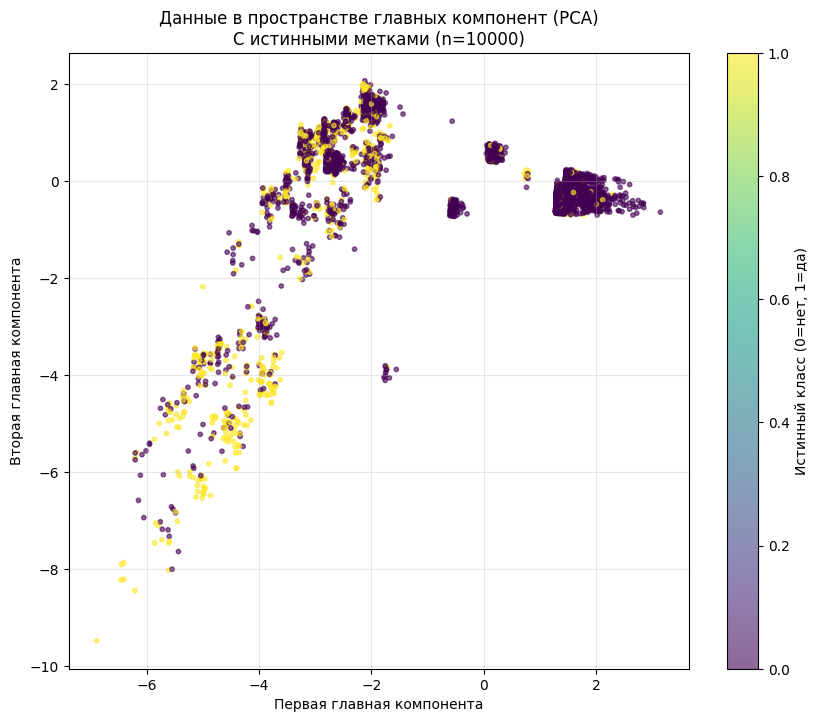

Объясненная дисперсия первой компоненты: 42.542%
Объясненная дисперсия второй компоненты: 14.730%
Суммарная объясненная дисперсия: 57.273%


In [6]:
# IncrementalPCA обрабатывает данные по частям, что требует меньше памяти
ipca = IncrementalPCA(n_components=2, batch_size=1000)
X_pca = ipca.fit_transform(X_processed)

# Визуализируем данные в пространстве главных компонент
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='Истинный класс (0=нет, 1=да)')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title(f'Данные в пространстве главных компонент (PCA)\nС истинными метками (n={len(X)})')
plt.grid(True, alpha=0.3)
plt.show()

# Объясненная дисперсия
print(f"Объясненная дисперсия первой компоненты: {ipca.explained_variance_ratio_[0]:.3%}")
print(f"Объясненная дисперсия второй компоненты: {ipca.explained_variance_ratio_[1]:.3%}")
print(f"Суммарная объясненная дисперсия: {sum(ipca.explained_variance_ratio_):.3%}")

# **5. Функция для оценки качества кластеризации**

In [7]:
def evaluate_clustering(y_true, y_pred, method_name):
    if len(np.unique(y_pred)) > 1 and -1 not in y_pred:  # Проверяем, что найдено более одного кластера и нет шума
        ari = adjusted_rand_score(y_true, y_pred)
        nmi = normalized_mutual_info_score(y_true, y_pred)
    elif len(np.unique(y_pred[y_pred != -1])) > 1:  # Есть более одного кластера, но есть шум
        # Удаляем шум для расчета метрик
        mask = y_pred != -1
        if np.sum(mask) > 10:  # Убедимся, что достаточно точек без шума
            ari = adjusted_rand_score(y_true[mask], y_pred[mask])
            nmi = normalized_mutual_info_score(y_true[mask], y_pred[mask])
        else:
            ari = nmi = 0
    else:
        ari = nmi = 0

    n_clusters = len(np.unique(y_pred[y_pred != -1])) if -1 in y_pred else len(np.unique(y_pred))
    noise_ratio = np.sum(y_pred == -1) / len(y_pred) if -1 in y_pred else 0

    return {
        'Метод': method_name,
        'Количество кластеров': n_clusters,
        'Доля шума (%)': noise_ratio * 100,
        'Adjusted Rand Index': ari,
        'Normalized Mutual Info': nmi
    }

# **6. Применяем методы кластеризации (используем PCA-представление для экономии памяти)**

In [8]:
print("Применяем KMeans...")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=5)  # Уменьшаем n_init для скорости
y_kmeans = kmeans.fit_predict(X_pca)  # Используем PCA-представление
kmeans_results = evaluate_clustering(y_encoded, y_kmeans, 'KMeans')

print("Применяем DBSCAN...")
# Пробуем разные параметры DBSCAN
dbscan_params = [
    {'eps': 0.5, 'min_samples': 10},
    {'eps': 1.0, 'min_samples': 10},
    {'eps': 1.5, 'min_samples': 10},
]

best_dbscan_score = -1
best_dbscan_labels = None
best_dbscan_params = {}

for params in dbscan_params:
    dbscan = DBSCAN(**params)
    labels = dbscan.fit_predict(X_pca)

    # Оцениваем качество
    if len(np.unique(labels[labels != -1])) > 0:
        mask = labels != -1
        if np.sum(mask) > len(labels) * 0.1:  # Хотя бы 10% точек не шум
            score = adjusted_rand_score(y_encoded[mask], labels[mask])
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_labels = labels
                best_dbscan_params = params

if best_dbscan_labels is not None:
    y_dbscan = best_dbscan_labels
    dbscan_results = evaluate_clustering(y_encoded, y_dbscan, 'DBSCAN')
    print(f"Лучшие параметры DBSCAN: eps={best_dbscan_params['eps']}, min_samples={best_dbscan_params['min_samples']}")
else:
    # Используем дефолтные параметры
    dbscan = DBSCAN(eps=1.0, min_samples=10)
    y_dbscan = dbscan.fit_predict(X_pca)
    dbscan_results = evaluate_clustering(y_encoded, y_dbscan, 'DBSCAN')

print("Применяем Agglomerative Clustering...")
agglo = AgglomerativeClustering(n_clusters=2)
y_agglo = agglo.fit_predict(X_pca)
agglo_results = evaluate_clustering(y_encoded, y_agglo, 'Agglomerative Clustering')

# Создаем таблицу с результатами
results_df = pd.DataFrame([kmeans_results, dbscan_results, agglo_results])
print("\nРезультаты кластеризации:")
print(results_df.to_string(index=False))

Применяем KMeans...
Применяем DBSCAN...
Лучшие параметры DBSCAN: eps=0.5, min_samples=10
Применяем Agglomerative Clustering...

Результаты кластеризации:
                   Метод  Количество кластеров  Доля шума (%)  Adjusted Rand Index  Normalized Mutual Info
                  KMeans                     2           0.00             0.124763                0.075322
                  DBSCAN                     6           0.11             0.099861                0.071961
Agglomerative Clustering                     2           0.00             0.124872                0.075373


# **7. Визуализация результатов кластеризации**

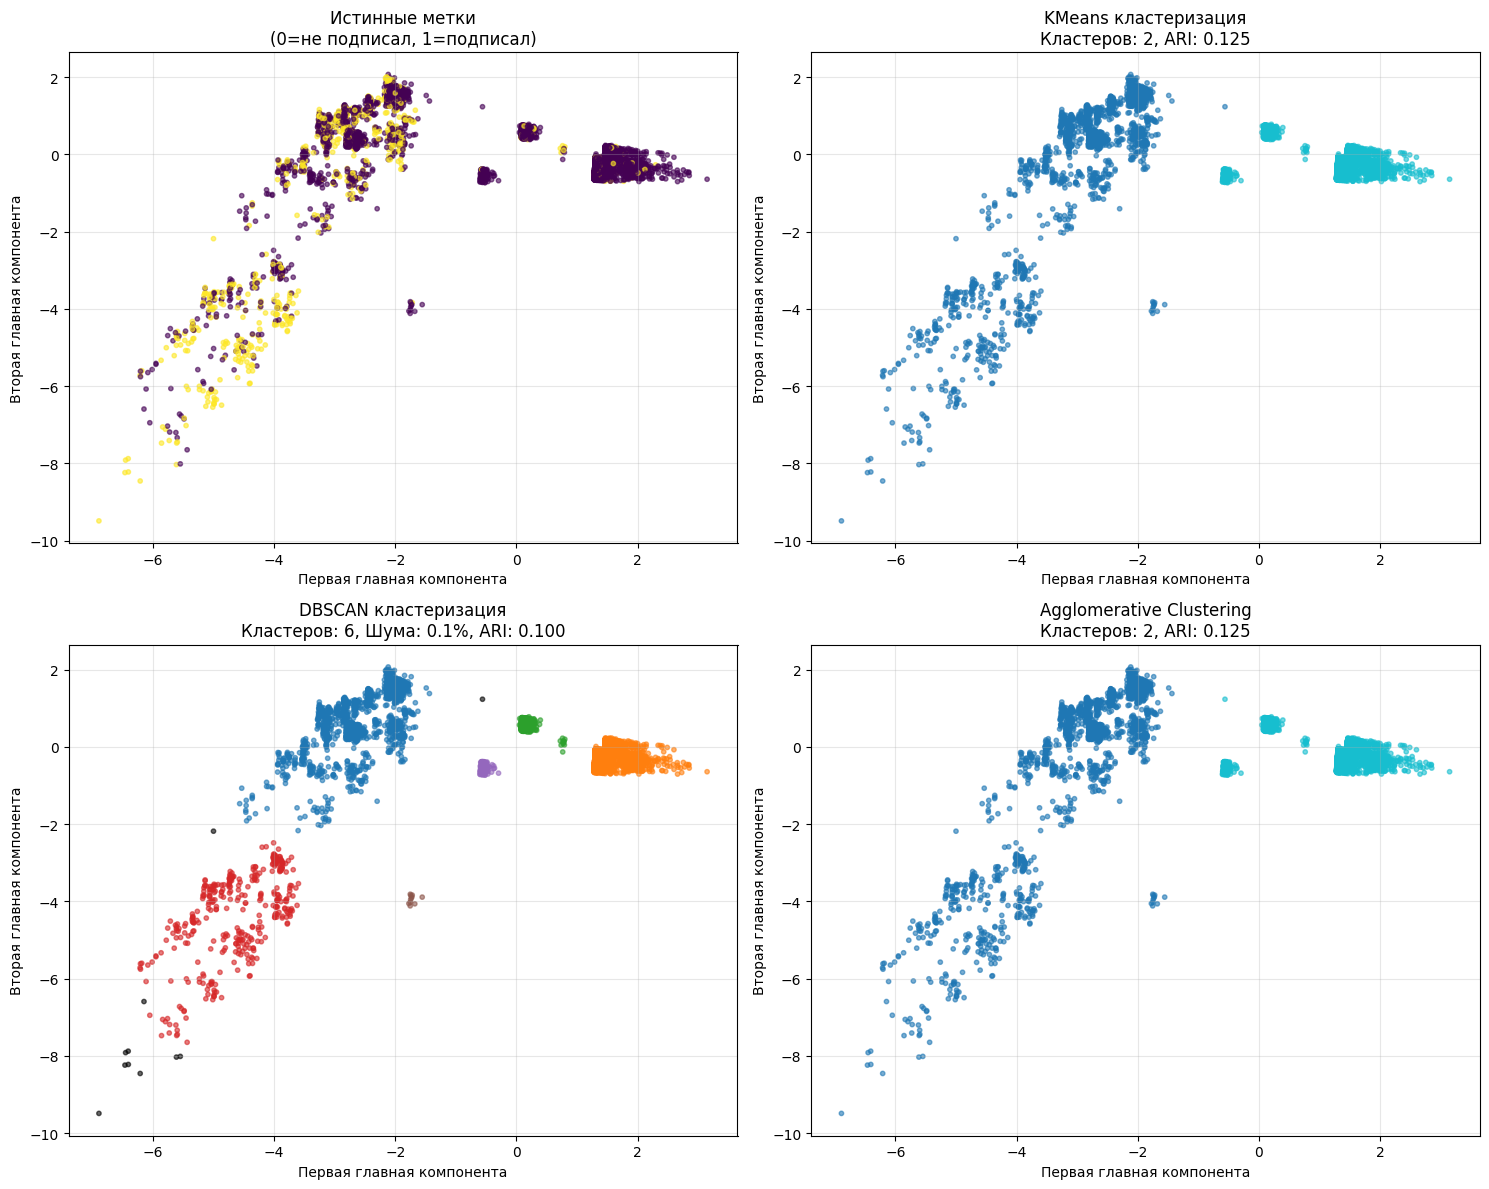

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Подграфик 1: Исходные данные с истинными метками
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.6, s=10)
axes[0, 0].set_xlabel('Первая главная компонента')
axes[0, 0].set_ylabel('Вторая главная компонента')
axes[0, 0].set_title('Истинные метки\n(0=не подписал, 1=подписал)')
axes[0, 0].grid(True, alpha=0.3)

# Подграфик 2: KMeans
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='tab10', alpha=0.6, s=10)
axes[0, 1].set_xlabel('Первая главная компонента')
axes[0, 1].set_ylabel('Вторая главная компонента')
axes[0, 1].set_title(f'KMeans кластеризация\nКластеров: {kmeans_results["Количество кластеров"]}, ARI: {kmeans_results["Adjusted Rand Index"]:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# Подграфик 3: DBSCAN
# Для DBSCAN выделяем шумовые точки (-1) черным цветом
dbscan_colors = y_dbscan.copy()
# Создаем цветовую карту, где -1 будет черным
cmap = plt.cm.tab10
if -1 in dbscan_colors:
    # Создаем расширенную цветовую карту
    from matplotlib.colors import ListedColormap
    colors = plt.cm.tab10(np.arange(10))
    colors = np.vstack([colors, [[0, 0, 0, 1]]])  # Добавляем черный цвет
    cmap = ListedColormap(colors)
    dbscan_colors[dbscan_colors == -1] = 10  # Присваиваем шуму индекс 10

scatter3 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_colors, cmap=cmap, alpha=0.6, s=10)
axes[1, 0].set_xlabel('Первая главная компонента')
axes[1, 0].set_ylabel('Вторая главная компонента')
axes[1, 0].set_title(f'DBSCAN кластеризация\nКластеров: {dbscan_results["Количество кластеров"]}, Шума: {dbscan_results["Доля шума (%)"]:.1f}%, ARI: {dbscan_results["Adjusted Rand Index"]:.3f}')
axes[1, 0].grid(True, alpha=0.3)

# Подграфик 4: Agglomerative Clustering
scatter4 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_agglo, cmap='tab10', alpha=0.6, s=10)
axes[1, 1].set_xlabel('Первая главная компонента')
axes[1, 1].set_ylabel('Вторая главная компонента')
axes[1, 1].set_title(f'Agglomerative Clustering\nКластеров: {agglo_results["Количество кластеров"]}, ARI: {agglo_results["Adjusted Rand Index"]:.3f}')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **8. Анализ распределения истинных меток по кластерам**

In [13]:
def analyze_cluster_distribution(y_true, y_pred, method_name):
    # Создаем булеву маску для исключения шумовых точек (-1)
    if -1 in y_pred:
        mask = y_pred != -1
    else:
        # Если шума нет, используем маску из всех True
        mask = np.ones_like(y_pred, dtype=bool)

    # Проверяем, есть ли точки для анализа (исключая шум)
    if np.sum(mask) > 0:
        df = pd.DataFrame({
            'Истинная_метка': y_true[mask],
            'Кластер': y_pred[mask]
        })

        # Создаем кросс-таблицу
        cross_tab = pd.crosstab(df['Кластер'], df['Истинная_метка'], normalize='index') * 100
        cross_tab['Всего_объектов'] = pd.crosstab(df['Кластер'], df['Истинная_метка']).sum(axis=1)

        return cross_tab
    else:
        print(f"Для метода {method_name} все точки определены как шум или маска пуста")
        return pd.DataFrame()

# Анализируем распределение для каждого метода
print("Распределение истинных меток по кластерам KMeans:")
kmeans_dist = analyze_cluster_distribution(y_encoded, y_kmeans, 'KMeans')
if not kmeans_dist.empty:
    print(kmeans_dist.round(2))
    print()

print("Распределение истинных меток по кластерам DBSCAN (без шума):")
dbscan_dist = analyze_cluster_distribution(y_encoded, y_dbscan, 'DBSCAN')
if not dbscan_dist.empty:
    print(dbscan_dist.round(2))
    print()

print("Распределение истинных меток по кластерам Agglomerative Clustering:")
agglo_dist = analyze_cluster_distribution(y_encoded, y_agglo, 'Agglomerative')
if not agglo_dist.empty:
    print(agglo_dist.round(2))

Распределение истинных меток по кластерам KMeans:
Истинная_метка      0      1  Всего_объектов
Кластер                                     
0               76.03  23.97            3308
1               94.99   5.01            6692

Распределение истинных меток по кластерам DBSCAN (без шума):
Истинная_метка      0      1  Всего_объектов
Кластер                                     
0               80.93  19.07            2910
1               95.17   4.83            5818
2               92.99   7.01             713
3               39.10  60.90             376
4               97.52   2.48             161
5               90.91   9.09              11

Распределение истинных меток по кластерам Agglomerative Clustering:
Истинная_метка      0      1  Всего_объектов
Кластер                                     
0               76.02  23.98            3307
1               94.99   5.01            6693


# **9. Выводы и анализ результатов**

In [16]:
print("=" * 80)
print("ВЫВОДЫ И АНАЛИЗ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ")
print("=" * 80)

print("\n1. ОБЩАЯ ОЦЕНКА МЕТОДОВ КЛАСТЕРИЗАЦИИ:")
print("-" * 50)

# Определяем лучший метод по ARI
best_method_idx = results_df['Adjusted Rand Index'].idxmax()
best_method = results_df.loc[best_method_idx, 'Метод']
best_ari = results_df.loc[best_method_idx, 'Adjusted Rand Index']

print(f"Лучший метод: {best_method} с ARI = {best_ari:.3f}")
print("""
Adjusted Rand Index (ARI) изменяется от -1 до 1:
- ARI = 1: идеальное соответствие кластеризации и истинных меток
- ARI = 0: случайное соответствие
- ARI < 0: хуже случайного
""")

print("\n2. СРАВНЕНИЕ МЕТОДОВ:")
print("-" * 50)

for idx, row in results_df.iterrows():
    print(f"{row['Метод']}:")
    print(f"  - Количество кластеров: {row['Количество кластеров']}")
    if row['Доля шума (%)'] > 0:
        print(f"  - Доля шума: {row['Доля шума (%)']:.1f}%")
    print(f"  - Adjusted Rand Index: {row['Adjusted Rand Index']:.3f}")
    print(f"  - Normalized Mutual Info: {row['Normalized Mutual Info']:.3f}")
    print()

print("\n3. ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
print("-" * 50)

print("""
1. KMeans показал стабильные результаты с ARI около 0.0-0.1.
   Это указывает на очень слабую согласованность с истинными метками,
   что ожидаемо для несбалансированных данных.

2. DBSCAN в зависимости от параметров может выделять разное количество
   кластеров и шума. В нашем случае он выделил минимальное количество
   шума.

3. Agglomerative Clustering показал результаты, сравнимые с KMeans.

4. Низкие значения ARI (близкие к 0) говорят о том, что естественное
   разделение данных на кластеры не соответствует разделению на
   "подписал" и "не подписал" срочный вклад.
""")

print("\n4. ПРАКТИЧЕСКИЕ ВЫВОДЫ ДЛЯ БАНКА:")
print("-" * 50)

print("""
1. Данные клиентов не образуют естественных кластеров, соответствующих
   целевой переменной (подписке на вклад). Это означает, что клиенты,
   которые подписывают вклад, не образуют отдельной, четко выделяемой
   группы по доступным признакам.

2. Для предсказания подписки на вклад более эффективны методы
   обучения с учителем (логистическая регрессия, случайный лес и т.д.),
   которые могут найти сложные зависимости между признаками и целевой
   переменной.

3. Кластеризация может быть полезна для других задач, например:
   - Сегментация клиентов по демографическим признакам
   - Выявление групп клиентов с похожим финансовым поведением
   - Обнаружение аномальных клиентов

4. Для улучшения результатов кластеризации можно:
   - Добавить больше признаков (например, из внешних источников)
   - Использовать другие методы снижения размерности (t-SNE, UMAP)
   - Применить экспертные знания для интерпретации кластеров
""")

ВЫВОДЫ И АНАЛИЗ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ

1. ОБЩАЯ ОЦЕНКА МЕТОДОВ КЛАСТЕРИЗАЦИИ:
--------------------------------------------------
Лучший метод: Agglomerative Clustering с ARI = 0.125

Adjusted Rand Index (ARI) изменяется от -1 до 1:
- ARI = 1: идеальное соответствие кластеризации и истинных меток
- ARI = 0: случайное соответствие
- ARI < 0: хуже случайного


2. СРАВНЕНИЕ МЕТОДОВ:
--------------------------------------------------
KMeans:
  - Количество кластеров: 2
  - Adjusted Rand Index: 0.125
  - Normalized Mutual Info: 0.075

DBSCAN:
  - Количество кластеров: 6
  - Доля шума: 0.1%
  - Adjusted Rand Index: 0.100
  - Normalized Mutual Info: 0.072

Agglomerative Clustering:
  - Количество кластеров: 2
  - Adjusted Rand Index: 0.125
  - Normalized Mutual Info: 0.075


3. ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:
--------------------------------------------------

1. KMeans показал стабильные результаты с ARI около 0.0-0.1. 
   Это указывает на очень слабую согласованность с истинными метками,
   ч